# Spotify Model Improvements

#### Areas for improvement

In the spotify_api_playlist_upload notebook, I discussed some potential areas to improve the recommendations of our initial model. Two of these points are reiterated below:

1. Create a categorical feature for "decade". We are currently turning year into a categorical variable for all unique values. This is an effective strategy, but when thinking of music, "decade" is often a powerful descriptor for type of song. Including decade as an additional feature could add correlation between songs released in the same decade, but different years.
2. Provide a weighting factor to reduce the weight of popular songs in our playlist vector. When we create our playlist vector, all songs are weighted equally. It might be interesting to reduce the impact of very popular songs when initially calculating this vector. From our results above, popular atrists seem to dominate our recommendations, which indicates that the popularity feature might be highly correlated. By reducing the weight of popular songs in the initial feature vector, the output songs might be less popular, and more likely to introduce new artists and music.

In [1]:
import spotipy
import requests
from spotipy.oauth2 import SpotifyClientCredentials
import json
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm

#### Import our cleaned dataset

In [2]:
spotify_df_improvements = pd.read_csv('data/clean_df.csv').iloc[:, 1:]
spotify_df_improvements.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,liveness,loudness,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
0,0.998996,['Carl Woitschach'],0.716599,0.028442,0.1950,0.0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,0.1510,0.745000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.997992,"['Robert Schumann', 'Vladimir Horowitz']",0.383603,0.051316,0.0135,0.0,6KuQTIu1KoTTkLXKrwlLPV,0.901,0.0763,0.494026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.606426,['Seweryn Goszczyński'],0.758097,0.018374,0.2200,0.0,6L63VW0PibdM1HDSBoqnoM,0.000,0.1190,0.627609,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.998996,['Francisco Canaro'],0.790486,0.032538,0.1300,0.0,6M94FkXd15sOAOQYRnWPN8,0.887,0.1110,0.708887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.993976,"['Frédéric Chopin', 'Vladimir Horowitz']",0.212551,0.126450,0.2040,0.0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,0.0980,0.676079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Create a dummy variable to account for decade released

In [3]:
cols = list(spotify_df_improvements.columns)
print(cols)

['acousticness', 'artists', 'danceability', 'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'liveness', 'loudness', 'name', 'popularity', 'speechiness', 'tempo', 'valence', 'year_1921', 'year_1922', 'year_1923', 'year_1924', 'year_1925', 'year_1926', 'year_1927', 'year_1928', 'year_1929', 'year_1930', 'year_1931', 'year_1932', 'year_1933', 'year_1934', 'year_1935', 'year_1936', 'year_1937', 'year_1938', 'year_1939', 'year_1940', 'year_1941', 'year_1942', 'year_1943', 'year_1944', 'year_1945', 'year_1946', 'year_1947', 'year_1948', 'year_1949', 'year_1950', 'year_1951', 'year_1952', 'year_1953', 'year_1954', 'year_1955', 'year_1956', 'year_1957', 'year_1958', 'year_1959', 'year_1960', 'year_1961', 'year_1962', 'year_1963', 'year_1964', 'year_1965', 'year_1966', 'year_1967', 'year_1968', 'year_1969', 'year_1970', 'year_1971', 'year_1972', 'year_1973', 'year_1974', 'year_1975', 'year_1976', 'year_1977', 'year_1978', 'year_1979', 'year_1980', 'year_1981', 'year_1982', 'year_

In [4]:
year_columns = cols[cols.index("year_1921"):]
year_columns_df = spotify_df_improvements[year_columns]
year_columns_df.head()

,year_1921,year_1922,year_1923,year_1924,year_1925,year_1926,year_1927,year_1928,year_1929,year_1930,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
categorical_decade = year_columns_df.idxmax(axis=1)
categorical_decade.head()

0    year_1928
1    year_1928
2    year_1928
3    year_1928
4    year_1928
dtype: object

In [6]:
categorical_decade = categorical_decade.apply(lambda x: int(x[5:-1] + '0'))
categorical_decade.head()

0    1920
1    1920
2    1920
3    1920
4    1920
dtype: int64

#### Include our new "decade" features in the database

In [7]:
spotify_df_improvements['decade'] = categorical_decade
spotify_df_improvements = pd.get_dummies(spotify_df_improvements, columns=['decade'])

#### Export scaled, cleaned, improved dataset for usage in other notebooks

In [8]:
spotify_keys = json.load(open('spotify_keys.json'))
path = spotify_keys["csv_path"] + "improved_df.csv"
spotify_df_improvements.to_csv(r'{}'.format(path))

#### Prepare keys to import custom playlists with the Spotify API

In [9]:
spotify_keys = json.load(open('spotify_keys.json'))
client_id = spotify_keys['client_id']
client_secret = spotify_keys['client_secret']

client_credentials_manager = SpotifyClientCredentials(client_id=client_id,client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#### Rebuild our playlist dataframe using an inputted playlist uri

Import a playlist uri, return the data within our master database related to each song. Also print out the number of songs in the playlist that were contained in our master database.

In [10]:
playlist_uri = "spotify:playlist:5BygwTQ3OrbiwVsQhXFHMz"
user = spotify_keys['username']

In [11]:
playlist = playlist_uri.split(":")[2]
results = sp.user_playlist(user, playlist, 'tracks')

playlist_song_uris = []

for song in results['tracks']['items']:
    playlist_song_uris.append(song['track']['id'])

print("The number of total songs in the playlist is: ", len(playlist_song_uris))

playlist_data = spotify_df_improvements[spotify_df_improvements['id'].isin(playlist_song_uris)]
print("The number of songs in the master database is: ", len(playlist_data))


The number of total songs in the playlist is:  100
The number of songs in the master database is:  74


In [12]:
display(playlist_data)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,liveness,loudness,...,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,decade_2020
29292,0.000033,['Nirvana'],0.441296,0.046305,0.876,0.0,3sKLf8SmgbyIikCTBZty9F,0.000104,0.2050,0.862861,...,0,0,0,0,0,0,1,0,0,0
55026,0.322289,['The Edgar Winter Group'],0.696356,0.034042,0.739,0.0,52MmMUuyjO64Y1EiF7Y8KH,0.011000,0.1740,0.790447,...,0,0,0,0,0,0,0,0,1,0
82642,0.008795,['Jimi Hendrix'],0.539474,0.030695,0.905,0.0,0wJoRiX5K5BxlqZTolB2LD,0.578000,0.0698,0.857098,...,0,0,0,1,0,0,0,0,0,0
82762,0.264056,"['Big Brother & The Holding Company', 'Janis J...",0.448381,0.045981,0.727,0.0,1xKQbqQtQWrtQS47fUJBtl,0.000141,0.1690,0.815112,...,0,0,0,1,0,0,0,0,0,0
82847,0.048594,['Led Zeppelin'],0.417004,0.060904,0.902,0.0,0hCB0YR03f6AmQaHbwWDe8,0.131000,0.4050,0.757967,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115254,0.025201,['Stevie Ray Vaughan'],0.431174,0.039777,0.693,0.0,1oT20g6f8rvymheUIdFr19,0.006500,0.1010,0.786798,...,0,0,0,0,0,0,0,1,0,0
115625,0.000014,['Foo Fighters'],0.364372,0.048693,0.905,0.0,4xanWVQIzdCf51mg8cd1cQ,0.000008,0.0753,0.879994,...,0,0,0,0,0,0,0,1,0,0
124579,0.007600,['Cheap Trick'],0.530364,0.046073,0.953,0.0,669cOBjpY4Y5O98Nmk6139,0.000005,0.7710,0.828486,...,0,0,0,0,0,0,0,1,0,0
133853,0.036145,['REO Speedwagon'],0.319838,0.036332,0.739,0.0,7CR06UPgZvsd2Y3MNjIVnA,0.000000,0.1870,0.848125,...,0,0,0,0,0,0,0,1,0,0


In [13]:
playlist_data['popularity']

29292     0.32
55026     0.49
82642     0.72
82762     0.68
82847     0.76
          ... 
115254    0.57
115625    0.59
124579    0.50
133853    0.50
168494    0.45
Name: popularity, Length: 74, dtype: float64

#### Define function to provide a dampening weight to songs with higher popularity

Songs with the highest popularity should be weighted the least, to prevent highly popular trends from having too much influence. 

Songs with the least popularity should be weighted the most, because they are harder to find. Therefore, they might have a greater correlation to the users true music taste.

The plot below uses a logorithmic function to gradually decrease in weight as popularity increases from 0 to 100.

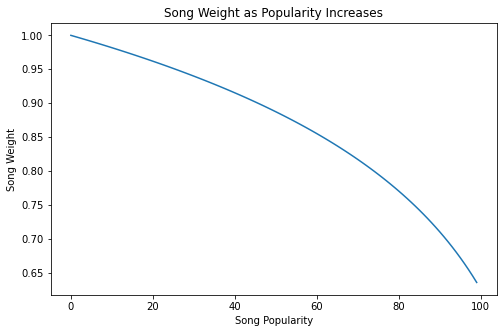

In [14]:
def formula(x):
    return np.log(-x + 120)/(np.log(120))

plt.figure(figsize = (8,5))
x = np.array(range(0,100))  
y = formula(x)
plt.plot(x, y)
plt.title("Song Weight as Popularity Increases")
plt.xlabel("Song Popularity")
plt.ylabel("Song Weight")
plt.show()  


In [15]:
# redefine our numberic feature function

def return_numeric_features(df):
    numeric_features = df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

    non_numeric_features = []
    for feat, value in numeric_features.iteritems():
        if value == False:
            non_numeric_features.append(feat)
            
    print('Non-numeric features: ', non_numeric_features)
    numeric_df = df.drop(non_numeric_features, axis=1)
    
    return numeric_df

In [16]:
numeric_playlist_data = return_numeric_features(playlist_data)
display(numeric_playlist_data)

Non-numeric features:  ['artists', 'id', 'name']


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,popularity,speechiness,...,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,decade_2020
29292,0.000033,0.441296,0.046305,0.876,0.0,0.000104,0.2050,0.862861,0.32,0.066770,...,0,0,0,0,0,0,1,0,0,0
55026,0.322289,0.696356,0.034042,0.739,0.0,0.011000,0.1740,0.790447,0.49,0.076780,...,0,0,0,0,0,0,0,0,1,0
82642,0.008795,0.539474,0.030695,0.905,0.0,0.578000,0.0698,0.857098,0.72,0.077812,...,0,0,0,1,0,0,0,0,0,0
82762,0.264056,0.448381,0.045981,0.727,0.0,0.000141,0.1690,0.815112,0.68,0.149639,...,0,0,0,1,0,0,0,0,0,0
82847,0.048594,0.417004,0.060904,0.902,0.0,0.131000,0.4050,0.757967,0.76,0.417957,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115254,0.025201,0.431174,0.039777,0.693,0.0,0.006500,0.1010,0.786798,0.57,0.038906,...,0,0,0,0,0,0,0,1,0,0
115625,0.000014,0.364372,0.048693,0.905,0.0,0.000008,0.0753,0.879994,0.59,0.083798,...,0,0,0,0,0,0,0,1,0,0
124579,0.007600,0.530364,0.046073,0.953,0.0,0.000005,0.7710,0.828486,0.50,0.042931,...,0,0,0,0,0,0,0,1,0,0
133853,0.036145,0.319838,0.036332,0.739,0.0,0.000000,0.1870,0.848125,0.50,0.034881,...,0,0,0,0,0,0,0,1,0,0


In [17]:
song_weights = numeric_playlist_data["popularity"].apply(lambda x: formula(x * 100))
display(song_weights)

29292     0.935216
55026     0.890379
82642     0.808607
82762     0.825326
82847     0.790433
            ...   
115254    0.865408
115625    0.858670
124579    0.887416
133853    0.887416
168494    0.901827
Name: popularity, Length: 74, dtype: float64

In [18]:
numeric_playlist_data["Song Weight"] = song_weights
display(numeric_playlist_data)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,popularity,speechiness,...,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,decade_2020,Song Weight
29292,0.000033,0.441296,0.046305,0.876,0.0,0.000104,0.2050,0.862861,0.32,0.066770,...,0,0,0,0,0,1,0,0,0,0.935216
55026,0.322289,0.696356,0.034042,0.739,0.0,0.011000,0.1740,0.790447,0.49,0.076780,...,0,0,0,0,0,0,0,1,0,0.890379
82642,0.008795,0.539474,0.030695,0.905,0.0,0.578000,0.0698,0.857098,0.72,0.077812,...,0,0,1,0,0,0,0,0,0,0.808607
82762,0.264056,0.448381,0.045981,0.727,0.0,0.000141,0.1690,0.815112,0.68,0.149639,...,0,0,1,0,0,0,0,0,0,0.825326
82847,0.048594,0.417004,0.060904,0.902,0.0,0.131000,0.4050,0.757967,0.76,0.417957,...,0,0,1,0,0,0,0,0,0,0.790433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115254,0.025201,0.431174,0.039777,0.693,0.0,0.006500,0.1010,0.786798,0.57,0.038906,...,0,0,0,0,0,0,1,0,0,0.865408
115625,0.000014,0.364372,0.048693,0.905,0.0,0.000008,0.0753,0.879994,0.59,0.083798,...,0,0,0,0,0,0,1,0,0,0.858670
124579,0.007600,0.530364,0.046073,0.953,0.0,0.000005,0.7710,0.828486,0.50,0.042931,...,0,0,0,0,0,0,1,0,0,0.887416
133853,0.036145,0.319838,0.036332,0.739,0.0,0.000000,0.1870,0.848125,0.50,0.034881,...,0,0,0,0,0,0,1,0,0,0.887416


#### Dataframe rows are now scaled based on the popularity weight

In [19]:
numeric_playlist_data = numeric_playlist_data.mul(numeric_playlist_data["Song Weight"], axis=0)
numeric_playlist_data = numeric_playlist_data.drop("Song Weight", axis=1)
display(numeric_playlist_data)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,popularity,speechiness,...,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,decade_2020
29292,0.000031,0.412706,0.043305,0.819249,0.0,0.000097,0.191719,0.806961,0.299269,0.062444,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.935216,0.000000,0.000000,0.0
55026,0.286959,0.620021,0.030310,0.657990,0.0,0.009794,0.154926,0.703797,0.436285,0.068363,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.890379,0.0
82642,0.007112,0.436222,0.024820,0.731790,0.0,0.467375,0.056441,0.693056,0.582197,0.062919,...,0.0,0.0,0.0,0.808607,0.0,0.0,0.000000,0.000000,0.000000,0.0
82762,0.217933,0.370060,0.037950,0.600012,0.0,0.000116,0.139480,0.672734,0.561222,0.123501,...,0.0,0.0,0.0,0.825326,0.0,0.0,0.000000,0.000000,0.000000,0.0
82847,0.038411,0.329614,0.048141,0.712970,0.0,0.103547,0.320125,0.599122,0.600729,0.330367,...,0.0,0.0,0.0,0.790433,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115254,0.021809,0.373142,0.034423,0.599728,0.0,0.005625,0.087406,0.680902,0.493283,0.033670,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.865408,0.000000,0.0
115625,0.000012,0.312876,0.041811,0.777096,0.0,0.000006,0.064658,0.755624,0.506615,0.071955,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.858670,0.000000,0.0
124579,0.006745,0.470654,0.040886,0.845707,0.0,0.000004,0.684197,0.735212,0.443708,0.038098,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.887416,0.000000,0.0
133853,0.032075,0.283829,0.032241,0.655800,0.0,0.000000,0.165947,0.752639,0.443708,0.030954,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.887416,0.000000,0.0


#### Define functions to build a final playlist vector from an inputted playlist uri

In [20]:
def build_playlist_vector(playlist_uri, user, reference_df):
    '''
    Given a playlist uri, load the playlist songs with the Spotify API. Identify which playlist songs are also in 
    the reference database. For these songs, generate a vector that summarizes the playlist. Return the vector and
    the reference database for making furthur predictions.
    
    Parameters: 
        playlist_uri (string): Unique spotify identifier for playlists
        user (string): Username associated with a Spotify developer account
        reference_df (df): Master database that contains all of the reference songs and their features
    
    Returns:
        averaged_playlist_vector (df): Dataframe with a single row entry summarizing all songs in the playlist
        updated_reference_df (df): Reference dataframe with all playlist songs removed to avoid predicting songs already in the playlist
    '''
    playlist = playlist_uri.split(":")[2]
    results = sp.user_playlist(user, playlist, 'tracks')
    
    playlist_song_uris = []
    for song in results['tracks']['items']:
        playlist_song_uris.append(song['track']['id'])
        
    print("The number of total songs in the playlist is: ", len(playlist_song_uris))
    
    playlist_df = reference_df[reference_df['id'].isin(playlist_song_uris)]
    print("The number of songs in the master database is: ", len(playlist_df))
        
    averaged_playlist_vector = generate_playlist_vector(playlist_df)

    # Remove songs from the reference dataframe that are also in the playlist
    numeric_reference_df = return_numeric_features(reference_df)
    updated_reference_df = numeric_reference_df.drop(index=playlist_df.index)
    
    return averaged_playlist_vector, updated_reference_df

In [21]:
# redefine our numberic feature function
def return_numeric_features(df):
    '''
    Take a dataframe with both numeric and text features, and return a dataframe with only the numerical features. In
    this case, features like "artist" and "name" will be removed, which are not needed for determining cosine 
    similarity.
    
    Parameters:
        df (df): Any dataframe
        
    Returns:
        numeric_df (df): A dataframe cleaned to only have numeric features
    '''
    numeric_features = df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

    non_numeric_features = []
    for feat, value in numeric_features.iteritems():
        if value == False:
            non_numeric_features.append(feat)
            
    numeric_df = df.drop(non_numeric_features, axis=1)
    
    return numeric_df

In [22]:
def generate_playlist_vector(playlist_df):
    '''
    Given a dataframe with data on our playlist songs, apply a weighting function to offset popularity. Once applied,
    take the mean along axis 0 to return an averaged playlist vector that can best represent the entire playlist.
    
    Parameters:
        playlist_df (df): Dataframe containing all songs within playlist that are also contained in the reference dataframe
        
    Returns:
        averaged_playlist_vector (df): Dataframe with a single entry, summarizing the playlist
    '''
    numeric_cleaned_df = return_numeric_features(playlist_df)

    song_weights = numeric_cleaned_df["popularity"].apply(lambda x: weight_formula(x * 100))
    numeric_cleaned_df["Song Weight"] = song_weights

    weighted_playlist_df = numeric_cleaned_df.mul(numeric_cleaned_df["Song Weight"], axis=0)
    weighted_playlist_df = weighted_playlist_df.drop("Song Weight", axis=1)
    
    averaged_playlist_vector = weighted_playlist_df.mean(axis=0)
    return averaged_playlist_vector

In [23]:
# redefine weighting formula for clarity
def weight_formula(popularity):
    '''
    Equation used to gradually dampen the value of higher popularities, which range from 0 to 100.
    
    Parameters:
        popularity (int): A popularity score ranging between 0 and 100
        
    Returns:
        (int): A weight used to scale the song vector
    '''
    return np.log(-popularity + 120)/(np.log(120))

#### We now have an updated playlist vector for a custom playlist entry

- This vector incorporates song decade and weight to offset song popularity
- We can test with the same playlist used in our previous notebook: "Classic Rock"

In [24]:
playlist_uri = "spotify:playlist:5BygwTQ3OrbiwVsQhXFHMz"

user = spotify_keys['username']

improved_playlist_vector, reference_df = build_playlist_vector(playlist_uri, user, spotify_df_improvements)
display(improved_playlist_vector)

The number of total songs in the playlist is:  100
The number of songs in the master database is:  74


acousticness    0.119448
danceability    0.422059
duration_ms     0.036818
energy          0.603949
explicit        0.021357
                  ...   
decade_1980     0.230737
decade_1990     0.155160
decade_2000     0.115920
decade_2010     0.012032
decade_2020     0.000000
Length: 123, dtype: float64

In [25]:
improved_playlist_vector

acousticness    0.119448
danceability    0.422059
duration_ms     0.036818
energy          0.603949
explicit        0.021357
                  ...   
decade_1980     0.230737
decade_1990     0.155160
decade_2000     0.115920
decade_2010     0.012032
decade_2020     0.000000
Length: 123, dtype: float64

#### Define functions for generating results given our new playlist vector

Return n highest scoring songs in our database based on cosine similarity

In [26]:
def cos_sim(row, playlist_vector):
    '''
    Function to return cosine similarity between two vectors.
    
    Parameters:
        row (df): Row of a dataframe that function will be applied to
        playlist_vector (df): Reference vector that will be compared to all rows
    
    Returns:
        (int): Cosine similarity score
    '''
    return dot(row, playlist_vector)/(norm(row)*norm(playlist_vector))

In [27]:
def predict_top_songs(playlist_vector, reference_df, original_reference_df, number_of_songs):
    '''
    Use a playlist vector and a reference dataframe to calculate the N most highly recommended songs to add to the 
    given playlist.
    
    Parameters:
        playlist_vector (df): Average vector summarizing the entries in the given playlist
        reference_df (df): Numerical dataframe with all playlist songs removed
        original_reference_df (df): Reference df including text features
        number_of_songs (int): Number of top songs to display
        
    Returns:
        top_songs (df): Dataframe showing the song, artist, and cosine score for the N most similar songs
    '''
    song_similarity_to_playlist = reference_df.apply(cos_sim, axis=1, args=(playlist_vector,))
    
    original_reference_df['cosine_similarity'] = song_similarity_to_playlist
    top_songs = original_reference_df.sort_values('cosine_similarity', ascending=False)
    top_songs = top_songs[['name', 'artists', 'cosine_similarity']].sort_values('cosine_similarity', ascending=False).head(number_of_songs)
    return top_songs

In [28]:
top_songs = predict_top_songs(improved_playlist_vector, reference_df, spotify_df_improvements, 30)
display(top_songs)

,name,artists,cosine_similarity
83976,You May Be Right,['Billy Joel'],0.849041
83967,Whip It,['DEVO'],0.847455
165894,Cheap Wine - 2011 Remastered,['Cold Chisel'],0.844112
83862,We Are Family,['Sister Sledge'],0.843946
83055,Brown Sugar - 2009 Mix,['The Rolling Stones'],0.843590
83952,Once in a Lifetime - 2005 Remaster,['Talking Heads'],0.843488
93802,Everybody Needs Somebody to Love,['The Blues Brothers'],0.843107
83988,What I Like About You,['The Romantics'],0.843092
93461,Sheena Is a Punk Rocker - 2017 Remaster,['Ramones'],0.842698
83852,I Was Made For Lovin' You,['KISS'],0.842244


# Conclusions

Our edited model appears to have selected many of the same songs as our initial model. This makes sense, as we only changed a variety of features to include additional information.

To show improvement with our new model, we want to see songs more concentrated in the decades of the original playlist (new decades features) and more unknown artists (weighted playlist vectors).

Both results are mostly concentrated on the 70s and 80s, but our new dataframe includes some new artists that were initially underrepresented. These include Boney M, The Police, Billy Ocean, and Earth, Wind & Fire.

Further improvements can be made by including genre-specific data in our source database.